In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install pyhive


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install thrift

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install thrift-sasl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
pip install textstat

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyhive import hive
from pyspark.ml.feature import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
#from textstat import textstatistics
from wordcloud import WordCloud


In [13]:
#Creating a Spark Session
spark = SparkSession.builder.appName("Hive Integration").enableHiveSupport().getOrCreate()

In [14]:
#Establishing a Connection to Hive
conn = hive.Connection(host="192.168.56.101", port=10000, username="cloudera",  password = 'cloudera', auth='CUSTOM')

In [15]:
#Reading a Table from Hive using conn
essay_df = pd.read_sql("select * from essays", conn)

C:\Users\hp\AppData\Local\Temp\ipykernel_20668\2771583432.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  essay_df = pd.read_sql("select * from essays", conn)


In [16]:
essay_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25956 entries, 0 to 25955
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   essays.essay_id        25956 non-null  object
 1   essays.essay_set       25956 non-null  object
 2   essays.essay           25954 non-null  object
 3   essays.rater1_domain1  25954 non-null  object
 4   essays.rater2_domain1  25954 non-null  object
 5   essays.domain1_score   25954 non-null  object
dtypes: object(6)
memory usage: 1.2+ MB


In [17]:
#Renaming the Column names
columns_to_rename = essay_df.columns
new_column_names = [col.replace("essays.", "") for col in columns_to_rename]
essay_df.columns = new_column_names
essay_df.columns

Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'domain1_score'],
      dtype='object')

In [18]:
#Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
essay_df['essay'] = essay_df['essay'].fillna('').astype(str)
essay_df['essay_clean'] = essay_df['essay'].apply(lambda x: re.sub('[^A-Za-z ]+', '', x))
essay_df['essay_clean'] = essay_df['essay_clean'].str.strip()
essay_df['tokens'] = essay_df['essay_clean'].str.split()
stop_words = set(stopwords.words('english'))
essay_df['filtered_words'] = essay_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

In [20]:
import textstat
from textstat.textstat import textstatistics

In [21]:
#Function to preprocess text (tokenize, remove punctuation, lowercase)

def preprocess_text(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha()]
    return words

#Function to calculate features for each essay
def analyze_essay(essay):
    words = preprocess_text(essay)
    sentences = sent_tokenize(essay)

    paragraphs = essay.split('\n\n')
    num_paragraphs = len(paragraphs)
    avg_paragraph_length = sum(len(p.split()) for p in paragraphs) / num_paragraphs if num_paragraphs > 0 else 0
    
    #Bag of Words Counts
    vectorizer = CountVectorizer(stop_words='english', token_pattern=r'\b\w+\b')
    try:
        bow_counts = vectorizer.fit_transform([essay]).toarray().sum()
    except ValueError:
        bow_counts = 0

    #Number of Words
    word_count = len(words)

    #Number of Sentences
    sentence_count = len(sentences)

    #POS Tagging
    pos_tags = pos_tag(words)
    noun_count = len([word for word, tag in pos_tags if tag.startswith('NN')])
    adj_count = len([word for word, tag in pos_tags if tag.startswith('JJ')])
    verb_count = len([word for word, tag in pos_tags if tag.startswith('VB')])
    adv_count = len([word for word, tag in pos_tags if tag.startswith('RB')])

    #Flesch Reading Ease
    fre_score = textstatistics().flesch_reading_ease(essay)

    #Average Sentence Length
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0

    #Sentence Complexity (Here, approximated by the variety of words)
    unique_word_count = len(set(words))
    sentence_complexity = unique_word_count / word_count if word_count > 0 else 0

    #Other features (like Number of Paragraphs, Average Paragraph Length, etc.) would require additional parsing rules

    return {
        'bow_counts': bow_counts,
        'word_count': word_count,
        'sentence_count': sentence_count,
        'noun_count': noun_count,
        'adj_count': adj_count,
        'verb_count': verb_count,
        'adv_count': adv_count,
        'fre_score': fre_score,
        'avg_sentence_length': avg_sentence_length,
        'sentence_complexity': sentence_complexity
    }

#Loading data
data = essay_df

#Applying the analysis to each essay
data['analysis'] = data['essay'].apply(analyze_essay)

pd.set_option('display.max_columns', None)  #Display any number of columns
pd.set_option('display.max_rows', None)     #Display any number of rows
pd.set_option('display.max_colwidth', None) #Display full width of each column
pd.set_option('display.width', None)  

#View the results
print(data['analysis'].head())

0                 {'bow_counts': 157, 'word_count': 326, 'sentence_count': 16, 'noun_count': 68, 'adj_count': 16, 'verb_count': 71, 'adv_count': 22, 'fre_score': 74.02, 'avg_sentence_length': 20.375, 'sentence_complexity': 0.4662576687116564}
1                  {'bow_counts': 191, 'word_count': 408, 'sentence_count': 20, 'noun_count': 99, 'adj_count': 19, 'verb_count': 85, 'adv_count': 15, 'fre_score': 67.08, 'avg_sentence_length': 20.4, 'sentence_complexity': 0.45098039215686275}
2      {'bow_counts': 129, 'word_count': 272, 'sentence_count': 14, 'noun_count': 75, 'adj_count': 19, 'verb_count': 51, 'adv_count': 13, 'fre_score': 68.2, 'avg_sentence_length': 19.428571428571427, 'sentence_complexity': 0.5147058823529411}
3    {'bow_counts': 273, 'word_count': 479, 'sentence_count': 27, 'noun_count': 131, 'adj_count': 41, 'verb_count': 93, 'adv_count': 28, 'fre_score': 60.24, 'avg_sentence_length': 17.74074074074074, 'sentence_complexity': 0.46555323590814196}
4    {'bow_counts': 188, 'wo

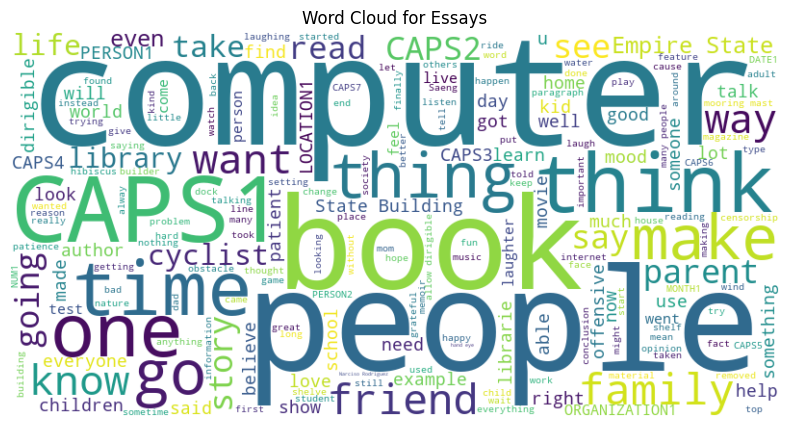

In [22]:
#Fill None values with an empty string 
data['essay'].fillna('', inplace=True)

#Generating a word cloud for essays
text = ' '.join(data['essay'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Essays')
plt.show()

In [23]:
#Convert empty strings to NaN
data['domain1_score'] = pd.to_numeric(data['domain1_score'], errors='coerce')

#Now check for missing values
print("Missing values in domain1_score:", data['domain1_score'].isnull().sum())

Missing values in domain1_score: 4


In [24]:
#Fill missing values with the median or another appropriate value
data['domain1_score'].fillna(data['domain1_score'].median(), inplace=True)

In [25]:
#Drop rows with missing 'domain1_score'
data.dropna(subset=['domain1_score'], inplace=True)

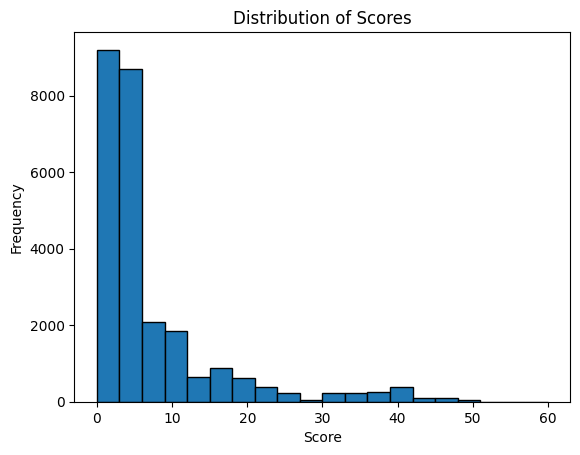

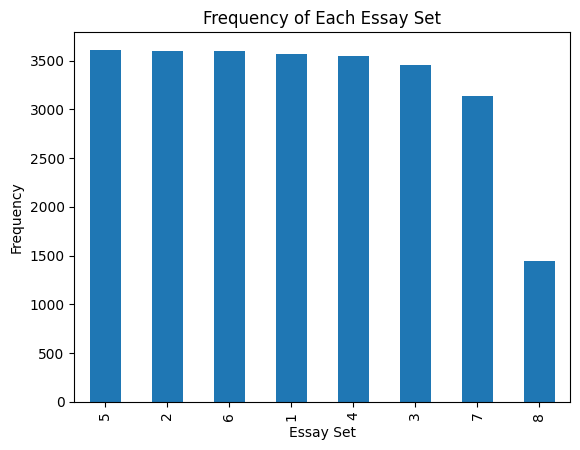

In [26]:
#Histogram of scores
plt.hist(data['domain1_score'], bins=20, edgecolor='black')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

#Frequency of essay sets 
data['essay_set'].value_counts().plot(kind='bar')
plt.title('Frequency of Each Essay Set')
plt.xlabel('Essay Set')
plt.ylabel('Frequency')
plt.show()

In [27]:
import numpy as np
#Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=[np.number])

#Compute the correlation matrix
corr_matrix = numeric_data.corr()

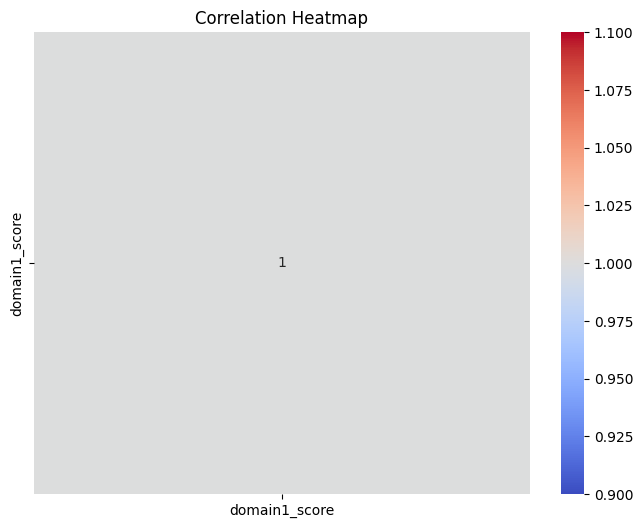

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

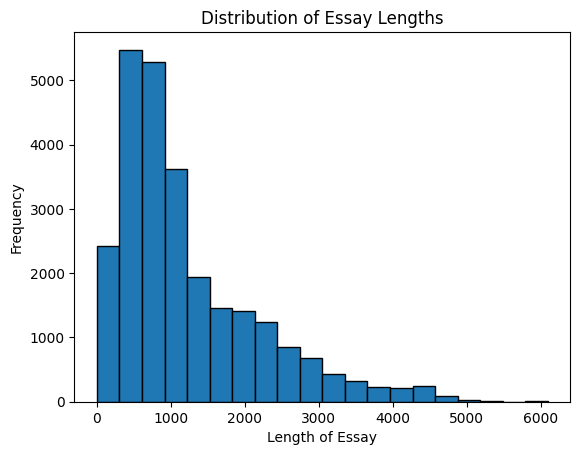

In [29]:
#Analyzing text length
data['essay_length'] = data['essay'].apply(len)

plt.hist(data['essay_length'], bins=20, edgecolor='black')
plt.title('Distribution of Essay Lengths')
plt.xlabel('Length of Essay')
plt.ylabel('Frequency')
plt.show()

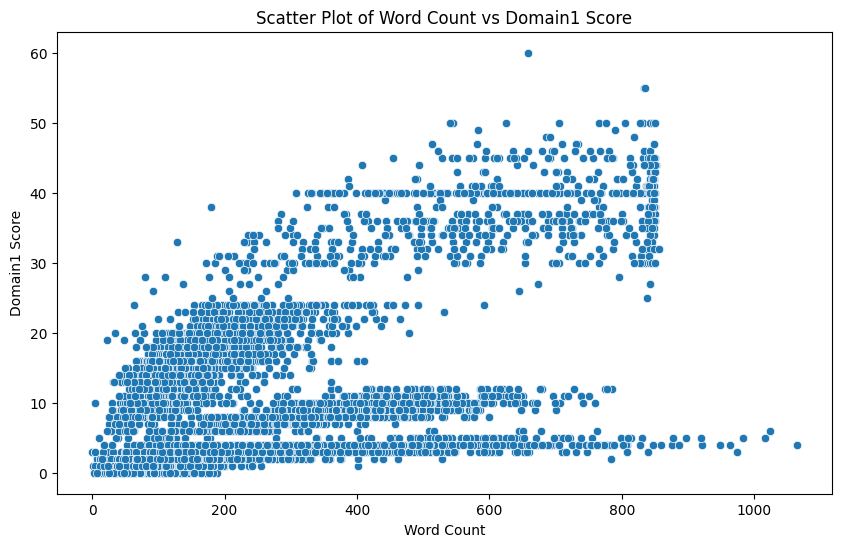

In [30]:

#Creating a word count feature

data['word_count'] = data['essay'].apply(lambda x: len(x.split()))

# Scatter plot of word count vs. domain1_score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='word_count', y='domain1_score', data=data)
plt.title('Scatter Plot of Word Count vs Domain1 Score')
plt.xlabel('Word Count')
plt.ylabel('Domain1 Score')
plt.show()

In [31]:
#Convert the 'analysis' column to a DataFrame where each feature is a separate column
features_df = pd.DataFrame(data['essay'].apply(analyze_essay).tolist())

data_combined = pd.concat([features_df, data['domain1_score']], axis=1)

#Combine the features with the target variable 'domain1_score'
data_combined = data_combined.apply(pd.to_numeric, errors='coerce')

#Check for missing values
print("Missing values in each column:\n", data_combined.isnull().sum())

#Option 2: Drop rows with missing values (use this if there are only a few rows with missing data)
data_combined.dropna(inplace=True)

#Define the feature matrix (X) and target vector (y) again, in case we modified the DataFrame
X = data_combined.drop('domain1_score', axis=1)
y = data_combined['domain1_score']


Missing values in each column:
 bow_counts             0
word_count             0
sentence_count         0
noun_count             0
adj_count              0
verb_count             0
adv_count              0
fre_score              0
avg_sentence_length    0
sentence_complexity    0
domain1_score          0
dtype: int64


In [32]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
#Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  r2_score

#Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Initialize and train the SVR model
svr_model = SVR(C=1.0, epsilon=0.2)
svr_model.fit(X_train_scaled, y_train)

#Predict and evaluate
svr_predictions = svr_model.predict(X_test_scaled)
svr_r2 = r2_score(y_test, svr_predictions)


print("Support Vector Regression - R-squared:", svr_r2)


Support Vector Regression - R-squared: 0.5402899034264363


In [35]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 trees in the forest
rf_model.fit(X_train_scaled, y_train)

# Predict and evaluate
rf_predictions = rf_model.predict(X_test_scaled)
rf_r2 = r2_score(y_test, rf_predictions)

print("Random Forest Regression - R-squared:", rf_r2)


Random Forest Regression - R-squared: 0.8746882719992883


In [36]:
from sklearn.linear_model import LinearRegression

# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Predict and evaluate
linear_predictions = linear_model.predict(X_test_scaled)
linear_r2 = r2_score(y_test, linear_predictions)

print("Linear Regression - R-squared:", linear_r2)


Linear Regression - R-squared: 0.4766865614829633


In [37]:
#Initialize regression models
regression_models = {
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso()
}

#Train regression models and extract coefficients
for name, model in regression_models.items():
    model.fit(X_train, y_train)
    coefficients = model.coef_
    print(f"{name} Coefficients:\n", coefficients)

Ridge Regression Coefficients:
 [ 0.0851825  -0.03195941  0.27278358 -0.14336054  0.06683253  0.10444549
  0.2030055   0.14489329  0.11249632  3.88335612]
Lasso Regression Coefficients:
 [ 0.08927296 -0.01656749  0.21682612 -0.15965253  0.01205217  0.0746362
  0.1672936   0.12773592  0.07762131  0.        ]


In [38]:
#Evaluate regression models
for name, model in regression_models.items():
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    print(f"{name}: R-squared = {r2}")

Ridge Regression: R-squared = 0.4766806145341511
Lasso Regression: R-squared = 0.4762969436312251


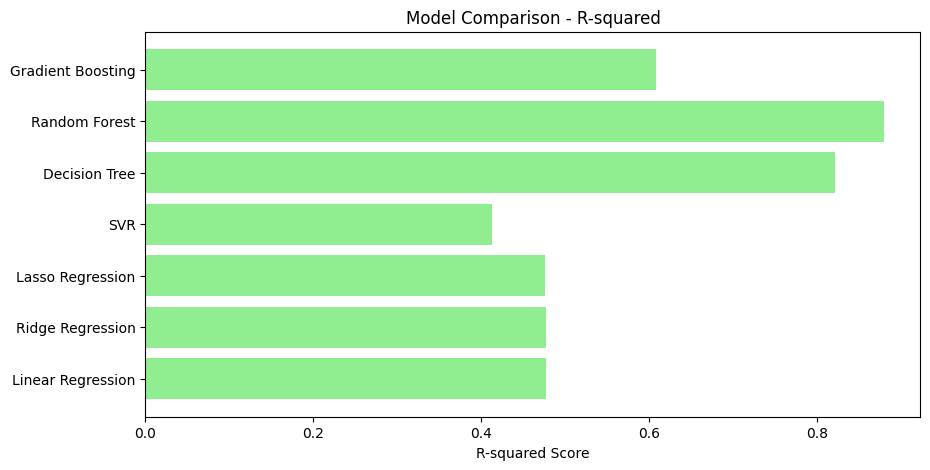

Model: Linear Regression
Coefficients:
[ 0.08514349 -0.03193077  0.27280112 -0.14331838  0.06681009  0.10446609
  0.20293145  0.14491647  0.1125252   3.91747936]


Model: Ridge Regression
Coefficients:
[ 0.0851825  -0.03195941  0.27278358 -0.14336054  0.06683253  0.10444549
  0.2030055   0.14489329  0.11249632  3.88335612]


Model: Lasso Regression
Coefficients:
[ 0.08927296 -0.01656749  0.21682612 -0.15965253  0.01205217  0.0746362
  0.1672936   0.12773592  0.07762131  0.        ]


Model: Decision Tree
Feature Importances:
[0.05982303 0.04659873 0.15113118 0.04600724 0.03881012 0.33158841
 0.05356811 0.13265796 0.05396958 0.08584566]


Model: Random Forest
Feature Importances:
[0.06116103 0.05697174 0.13793967 0.04742742 0.04119964 0.30098215
 0.08273041 0.12890531 0.05497505 0.08770757]


Model: Gradient Boosting
Feature Importances:
[0.1186699  0.01984236 0.11296286 0.01668852 0.01858562 0.27944399
 0.20105568 0.14686257 0.0263678  0.05952069]




In [39]:
#Initialize the regression models (excluding Logistic Regression)
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

#Dictionary to store model coefficients or feature importances
model_coefficients = {}

#Train models, store coefficients or feature importances
for name, model in models.items():
    model.fit(X_train, y_train)
    
    #For linear models, store coefficients
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        coefs = model.coef_
        model_coefficients[name] = coefs
    #For tree-based models, store feature importances
    elif name in ['Decision Tree', 'Random Forest', 'Gradient Boosting']:
        importances = model.feature_importances_
        model_coefficients[name] = importances

#Evaluate models and plot results
r2_values = []
model_names = []

for name, model in models.items():
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    r2_values.append(r2)
    model_names.append(name)

#Plotting R-squared values
plt.figure(figsize=(10, 5))
plt.barh(model_names, r2_values, color='lightgreen')
plt.xlabel('R-squared Score')
plt.title('Model Comparison - R-squared')
plt.show()

#Display coefficients or feature importances
for model_name, coefs in model_coefficients.items():
    print(f"Model: {model_name}")
    print("Coefficients:" if model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression'] else "Feature Importances:")
    print(coefs)
    print("\n")
